# Tweets Analysis with BERT

In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
#use pandas to read the csv file as a tadtfram, and att header to your data
testset = pd.read_csv("hasoc2019_en_test-2919.tsv",sep='\t')
trainset = pd.read_csv("english_dataset.tsv",sep="\t")
#set id as index --- this helps in moving  arround the dataframe 
testset.set_index('id',inplace=True)
trainset.set_index('id',inplace=True)

In [4]:
#see the first five row of your data
trainset.head()
#you can notice now the id is bold which means it is an index  not data any more

,tweet,task_1,task_2,task_3
id,,,,
hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE
hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN
hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE
hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE
hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE


### data pre preocessing 
- check data balance
- remove unuseful data(nocode,not-relevent)
- convert category to integer label


In [6]:
#check data balance
#count howmany time each uniqe instance in our data
total=[trainset,testset]
#Ignoring indexes on the concatenation axis¶
total_data=pd.concat(total, ignore_index=True, sort=False)
total_data.task_1.value_counts()

NOT    4456
HOF    2549
Name: task_1, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


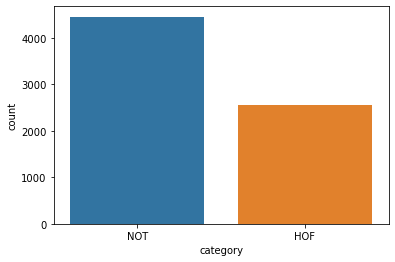

In [7]:
import seaborn as sns
from matplotlib import pyplot

sns.countplot(total_data.task_1)
pyplot.xlabel('category');

## you can see now we have class imbalance and we need to deal with it

In [8]:
#get  unique labels from category
labels = total_data.task_1.unique()#  you can use labels = set(df['category']) 
print(labels)# {sad', 'disgust', 'surprise', 'not-relevant', 'happy', 'angry'}

#Build  a dictionary  to map emotions to integer
#emo2int={'happy':'0','not-relevant':'1','angry':'2','surprise ':'3','sad':'4'}
#more automated  way to that 
emo2int = {}
for index, label in enumerate(labels):#enumerate() takes iterator (set,list,dic,..etc)and returns tuple of index and the value 
    emo2int[label] = index 
print(emo2int)

['NOT' 'HOF']
{'NOT': 0, 'HOF': 1}


In [10]:
#replace 
#dataframe.replace() function is used to replace a string, regex, list, dictionary, series, number etc. from a dataframe
total_data['label'] = total_data.task_1.replace(emo2int)
total_data.head()

,tweet,task_1,task_2,task_3,label
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE,0
1,@politico No. We should remember very clearly ...,HOF,HATE,TIN,1
2,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE,0
3,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE,0
4,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE,0


## Class imbalance  and train/test split
### we will split each class to make sure all classes appear in the train/val/test dataset 

In [14]:
#we splite the text and labels
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(total_data['tweet'], total_data['label'], test_size=0.15, random_state=0, stratify=total_data['label'])#we use stratify to make sure we splite according to all classes
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 3787, 1: 2167})
Counter({0: 669, 1: 382})


5954
Counter({0: 3787, 1: 2167})


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'train labels')

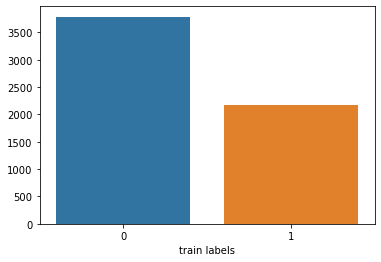

In [15]:
##we can also split according to the index 
X_train, X_val, y_train, y_val = train_test_split( total_data.index.values, total_data['label'],test_size = 0.15,random_state=17,stratify=total_data['label'])
print(len(y_train))
print(Counter(y_train))

sns.barplot(list(Counter(y_train).keys()), list(Counter(y_train).values()))
pyplot.xlabel('train labels')

Counter({0: 669, 1: 382})
1051


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'test labels')

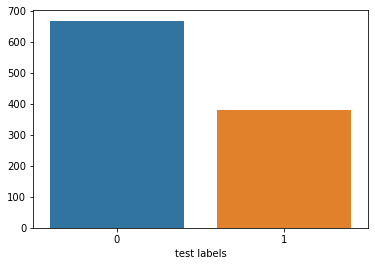

In [16]:
print(Counter(y_test))
print(len(y_test))
sns.barplot(list(Counter(y_test).keys()), list(Counter(y_test).values()))
pyplot.xlabel('test labels')

In [19]:
total_data['data_type'] = ['not_set']*total_data.shape[0]
total_data.head()

,tweet,task_1,task_2,task_3,label,data_type
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE,0,not_set
1,@politico No. We should remember very clearly ...,HOF,HATE,TIN,1,not_set
2,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE,0,not_set
3,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE,0,not_set
4,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE,0,not_set


In [20]:
total_data.loc[X_train, 'data_type'] = 'train'
total_data.loc[X_val, 'data_type'] = 'val'
total_data.head()

,tweet,task_1,task_2,task_3,label,data_type
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE,0,train
1,@politico No. We should remember very clearly ...,HOF,HATE,TIN,1,train
2,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE,0,val
3,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE,0,train
4,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE,0,train


 ## Loading Tokenizer and Encoding our Data
 - now we want to tokenize the tweets(text) which mean splits the sentence into words 
 - after tokenization we will encode the words(convert them into integer number)

In [21]:
#Bert model can do all these tasks mentioned  above
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [22]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [23]:
#both  encoded_data will return dictionary 
encoded_data_train = tokenizer.batch_encode_plus(
    total_data[total_data.data_type == 'train'].tweet.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    total_data[total_data.data_type == 'val'].tweet.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(total_data[total_data.data_type == 'train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(total_data[total_data.data_type == 'val'].label.values)

In [26]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [27]:
len(dataset_train)

5954

In [28]:
len(dataset_val)

1051

In [29]:
### setup Bert-pre-trained Model

In [30]:
from transformers import BertForSequenceClassification


In [31]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels = len(emo2int),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### what we did above, we already knew  that BERT essentially takes in text and is able to encode it in a meaningful way based on this huge corpus of data that it was initially trainedon.We want to use this pre-trained model and fine tuning it by  adding and layer on top of it of size 6(number of our classes) because we've got six difference classes that we want to be able to predict.


## Loading data with Loaders


In [32]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 4#32

dataloader_train = DataLoader(
    dataset_train,
    sampler = RandomSampler(dataset_train),
    batch_size = batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler = RandomSampler(dataset_val),
    batch_size = 32
)

## Setting Up Optimizer and Schedule

In [33]:
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr=1e-5,# 2e-5 ... 5e-5 
                  eps=1e-8)
epochs = 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = len(dataloader_train)*epochs)

##  Defining our Performance Metrics

In [34]:
import numpy as np
from sklearn.metrics import f1_score


In [35]:

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1). flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [36]:
def accuracy_per_class(preds, labels):
    labels_dict_inverse = {v: k for k, v in emo2int.items()}
    
    preds_flat = np.argmax(preds, axis = 1). flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {labels_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])/len(y_true)}')

In [37]:
#Start Training 

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [39]:
#The seed() method is used to initialize the random number generator.
#A random seed specifies the start point when a computer generates a random number sequence.
#When you ask for random number in pytorch (with torch.rand() or t.uniform_() for example) these random numbers are generated from a specific algorithm.
#A nice property of this algorithm is that you can fix it’s starting point and it will always generate the same random numbers afterwards. That way, you can have reproducible code even with random functions in it.
#The seed is just this starting point.

In [42]:

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [43]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [44]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch),
                       leave=False,
                       disable=False)
    
    for batch in progress_bar:
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f'./BERT2_ft_epoch{epoch}.model')
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1489 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6115661630991164


  0%|          | 0/33 [00:00<?, ?it/s]

Validation loss: 0.572626022678433
F1 Score (weighted): 0.6944581690162114


Epoch 2:   0%|          | 0/1489 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5250233539534623


  0%|          | 0/33 [00:00<?, ?it/s]

Validation loss: 0.6891982302521215
F1 Score (weighted): 0.6988823708548755


Epoch 3:   0%|          | 0/1489 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.49356744949667747


  0%|          | 0/33 [00:00<?, ?it/s]

Validation loss: 1.0507998177499482
F1 Score (weighted): 0.7149033439915145


Epoch 4:   0%|          | 0/1489 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.391101350999219


  0%|          | 0/33 [00:00<?, ?it/s]

Validation loss: 1.2964454672553323
F1 Score (weighted): 0.6986168871366724


Epoch 5:   0%|          | 0/1489 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.2920576767255399


  0%|          | 0/33 [00:00<?, ?it/s]

Validation loss: 1.4790584607557817
F1 Score (weighted): 0.6971876902940234


In [45]:
model.load_state_dict(
    torch.load('BERT2_ft_epoch2.model', 
               map_location=torch.device('cpu')))

<All keys matched successfully>

In [46]:
_, predictions, true_vals = evaluate(dataloader_val)

  0%|          | 0/33 [00:00<?, ?it/s]

In [47]:
accuracy_per_class(predictions, true_vals)

Class: NOT
Accuracy: 0.8639760837070254
Class: HOF
Accuracy: 0.450261780104712
